In [38]:
# Importing necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data preprocessing

###Read data

In [39]:
# Load data
df = pd.read_csv('/BA_trainmodel/data/NTR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


###Reset index

In [40]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [41]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
#df_Close = df_Close.dropna() # Drop missing values
df_Close = df_Close.reset_index(drop=True) # Reset the index
df_Close.head(20)

,Close
0,46.259998
1,45.049999
2,47.130001
3,47.740002
4,49.209999
5,49.410000
6,50.049999
7,49.869999
8,49.680000
9,49.669998


###Data normalization

In [42]:
# Scaling the data
scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(df_Close)
data_scaled

array([[0.23668902],
       [0.22315435],
       [0.24642059],
       ...,
       [0.37852348],
       [0.37684565],
       [0.38601791]])

###Data splitting

In [43]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

In [44]:
def create_dataset(dataset, time_step, prev_data=None):
    dataX, dataY = [], []
    start_index = 0
    
    # If previous data is available
    if prev_data is not None:
        start_index = max(0, time_step - len(prev_data))
        dataset = np.concatenate((prev_data, dataset))
        
    for i in range(start_index, len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)


##Model training and testing

###Define the parameter GBT

In [45]:
# Grid of time_steps to try
time_step_grid = [30, 50, 60, 70, 100]

In [46]:
# Define the parameter grid
param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4]
}


In [47]:
# Defining the GBT Model
gbt = GradientBoostingRegressor(n_iter_no_change=5, tol=0.02, random_state=0)

In [48]:
random_search = RandomizedSearchCV(estimator=gbt, param_distributions=param_grid, n_iter=100, cv=10, verbose=2, random_state=0, n_jobs=-1)

In [51]:
best_params = None
best_val_RMSE = float('inf')
best_time_step = None
best_gbt = None

In [52]:
for time_step in time_step_grid:
    # Reshape into X=t,t+1,t+2..t+time_step_grid[i] and Y=t+time_step_grid[i]
    X_train, y_train = create_dataset(train_data, time_step)

    # Prepare previous data for validation set
    last_train_data = train_data[-time_step:]

    # Create validation set
    X_val, y_val = create_dataset(val_data, time_step, last_train_data)

    # Fitting the random search model
    random_search.fit(X_train, y_train)

    # Create a new model with these parameters
    candidate_gbt = GradientBoostingRegressor(**random_search.best_params_, random_state=0)

    # Fit the model with the training data
    candidate_gbt.fit(X_train, y_train)

    # Predicting on validation data
    y_pred_val = candidate_gbt.predict(X_val)
    y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1,1))
    y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))

    valid_RMSE =  mean_squared_error(y_val_inv, y_pred_val_inv, squared=False)
    # Check if this model is better than the previous ones
    if valid_RMSE < best_val_RMSE:
        best_params = random_search.best_params_
        best_val_RMSE = valid_RMSE
        best_time_step = time_step
        best_gbt = candidate_gbt
        best_y_pred_val_inv = y_pred_val_inv
        best_y_val_inv = y_val_inv

    # Print the RMSE for this time_step
    print(f"Time step: {time_step}, Validation RMSE: {valid_RMSE}")

print("Best time step: ", best_time_step)
print("Best parameters: ", best_params)
print("Validation RMSE with best time step and parameters: ", best_val_RMSE)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 30, Validation RMSE: 23.714380501330716
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 50, Validation RMSE: 25.135694234884717
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 60, Validation RMSE: 23.584417210485842
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 70, Validation RMSE: 23.40371728370017
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 100, Validation RMSE: 23.58715223933235
Best time step:  70
Best parameters:  {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 6, 'learning_rate': 0.15}
Validation RMSE with best time step and parameters:  23.40371728370017


##Train with best time step and best parameters

In [53]:
# Once we have the best params and time step, we recreate all datasets and fit the model again
X_train, y_train = create_dataset(train_data, best_time_step)
X_val, y_val = create_dataset(val_data, best_time_step)


# Prepare previous data for test set
last_points_train = val_data[-best_time_step:]
X_test, y_test = create_dataset(test_data, best_time_step, last_points_train)

In [54]:
# Create a new model with the best parameters
best_gbt = GradientBoostingRegressor(**best_params, random_state=0)

In [55]:
# Create a new model with the best parameters
best_gbt.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

GradientBoostingRegressor(learning_rate=0.15, max_depth=6, min_samples_leaf=4,
                          min_samples_split=3, n_estimators=500,
                          random_state=0)

In [56]:
# Now use this to make predictions
y_pred_test=best_gbt.predict(X_test)


##Testing process

In [57]:
# And scale the predictions back to the original range
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1,1))



In [58]:
test_MAPE = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_RMSE = mean_squared_error(y_test_inv, y_pred_test_inv, squared=False)
test_MSLE = mean_squared_log_error(y_test_inv, y_pred_test_inv)
print('MAPE on the data test:', test_MAPE)
print('RMSE on the data test', test_RMSE)
print('MSLE on the data test', test_MSLE)

MAPE on the data test: 0.050686869250690686
RMSE on the data test 4.701928285383523
MSLE on the data test 0.0042427057251350495


##Predicting the next 30 days

In [59]:
# Predict the closing prices for the next 30 days
x_input=test_data[-best_time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=best_time_step
i=0
while(i<30):
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        next_date = best_gbt.predict(x_input)
        print("{} day output {}".format(i,next_date))
        temp_input.extend(next_date.tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(next_date.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps))
        next_date = best_gbt.predict(x_input)
        print(next_date[0])
        temp_input.extend(next_date.tolist())
        print(len(temp_input))
        lst_output.extend(next_date.tolist())
        i=i+1


0.45513762651452133
71
1 day input [0.62718119 0.60950779 0.62885906 0.6005593  0.56677849 0.54776286
 0.57058167 0.5355705  0.53221477 0.53255032 0.54507832 0.56062641
 0.5511186  0.53836692 0.52203576 0.53031322 0.52628638 0.53255032
 0.53221477 0.54530199 0.54854585 0.53624162 0.51823266 0.47997765
 0.51554812 0.53914992 0.52695748 0.53523487 0.53501119 0.55682323
 0.5459732  0.53747206 0.52572705 0.50917229 0.51599556 0.49642062
 0.49183445 0.49105145 0.49552575 0.50055926 0.48847871 0.46923941
 0.42684562 0.44675616 0.44071588 0.43333333 0.42796422 0.40984342
 0.38914988 0.41521254 0.41342283 0.40268454 0.4067114  0.4121924
 0.40111856 0.39328857 0.36442953 0.34977628 0.34440715 0.32807606
 0.30872484 0.31689038 0.33210292 0.33836687 0.35928413 0.38299776
 0.37852348 0.37684565 0.38601791 0.45513763]
1 day output [0.46554751]
2 day input [0.60950779 0.62885906 0.6005593  0.56677849 0.54776286 0.57058167
 0.5355705  0.53221477 0.53255032 0.54507832 0.56062641 0.5511186
 0.53836692 

In [60]:
lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))
print('Predicted closing prices for the next 30 days:')
print(lst_output)

Predicted closing prices for the next 30 days:
[[65.78930381]
 [66.71994724]
 [66.85610003]
 [66.93589542]
 [67.49474901]
 [68.59840834]
 [68.68937919]
 [68.75113794]
 [68.19573857]
 [68.484926  ]
 [69.38514299]
 [69.29631994]
 [68.58147292]
 [68.31771674]
 [68.16851004]
 [68.31660065]
 [65.41103447]
 [67.10727779]
 [65.66244631]
 [64.73769291]
 [66.63507743]
 [65.49275961]
 [65.7923654 ]
 [66.35146647]
 [66.30851962]
 [66.12058577]
 [64.96235604]
 [65.55185613]
 [65.43594617]
 [64.30859343]]


##Preparing the forecast date index

##Visualization

In [61]:
# Convert integer indexes back to datetime
train_data_index = df.index[:train_size]
val_data_index = df.index[train_size:train_size+ val_size]
test_data_index = df.index[train_size + val_size:]

# Assuming predict_data_index is the 30 days following the last date in the validation data
predict_data_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

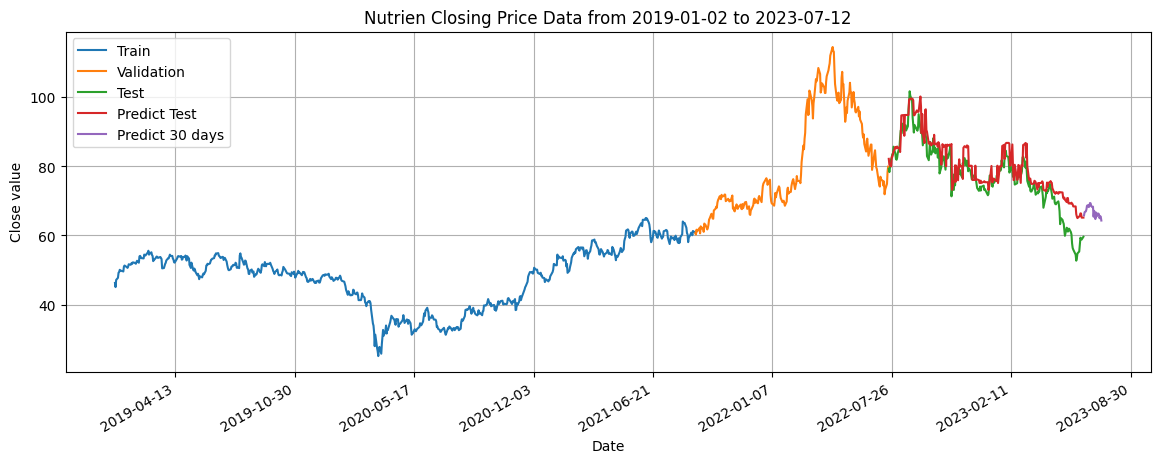

In [62]:
# Plotting Data
plt.figure(figsize=(14, 5))
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validation')
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred_test_inv, label='Predict Test')

plt.plot(predict_data_index, lst_output, label='Predict 30 days')
# Thiết lập mốc ngày trên trục x
plt.grid()
plt.title(f"Nutrien Closing Price Data from {train_data_index[0].strftime('%Y-%m-%d')} to {predict_data_index[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) # Select markers spaced 200 days apart
plt.gcf().autofmt_xdate() #  Rotate date labels for better readability
plt.legend()
plt.savefig('../Image/GBT_622_NTR.png')
plt.show()